Recommender Systems are a huge part of our daily lives and are used in almost all online services in one form or another. They are used to suggest things we might like to buy, movies we might like to watch and people that we might like to add to our social network.

The benefits of Recommender Systems are two-fold. Firstly, from a customer/user perspective, getting accurate recommendations will mean that less time is spent searching for the correct item/time is not wasted on incorrect items, which improves the user experience. From a service-provider perspective, users are more likely to interact if the user experience is good. More accurate recommendations lead to more interactions and usually to higher revenue.

In this notebook I will be exploring the [MovieLens dataset](https://grouplens.org/datasets/movielens/), a repository of over 26,000,000 movie ratings given to 45,000 movies by 270,000 users. Many thanks to them for collecting this data and making it available to the public.


## This notebook contains the following content:
* [1. Data Exploration](#first-bullet)
* [2. Building the Recommender System](#second-bullet)
* [3. Improvements/Further Work](#third-bullet)

## 1. Data Exploration <a class="anchor" id="first-bullet"></a>
It is always important to understand the data before we dive into model building. We can even potentially get interesting information from simple plots & analysis. The first step is to import the data and look at the rows/columns present:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ratings = pd.read_csv('Movie Recommender/ratings.csv')
movies = pd.read_csv('Movie Recommender/movies.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
movieId    45843 non-null int64
title      45843 non-null object
genres     45843 non-null object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


The ratings dataframe contains the userId of the user giving the rating, the movieId of the movie being rated, the rating (ranges from 0.5 - 5 in increments of 0.5) and a timestamp of when the rating was given. There are over 26 million rows and no missing values.

The movies dataframe contains the movieId, title and a '|' delimited list of genres for each movie. There are over 45,000 rows and no missing values.

So far, so good. Let's look at the unique occurences of users and movies.

In [7]:
n_users=(ratings.userId.nunique()) # number of unique reviewers
n_movies=(ratings.movieId.nunique()) # number of unique movies
print('There are ' + str(n_users) + ' unique users.')
print('There are ' + str(n_movies) + ' unique movies.')

There are 270896 unique users.
There are 45115 unique movies.


In [8]:
max_userId = ratings.userId.max() # maximum value of userID
max_movieId = ratings.movieId.max() # maximum value of movieId
print('Max userID is ' + str(max_userId))
print('Max movieID is ' + str(max_movieId))

Max userID is 270896
Max movieID is 176275


Note that the number of unique movies rated is less than the total number of movies with Id's, and also the maximum movie Id is much higher than the number of unique movies. This means that the movieId's are not consecutive numbers, and there are some movies without any ratings.

Let's see how the ratings are distributed.

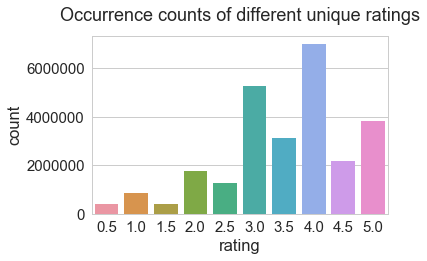

In [9]:
sns.set(font_scale=1.5, style='whitegrid')
sns.countplot(ratings['rating'])
plt.title('Occurrence counts of different unique ratings', y=1.05)
plt.tight_layout()

We can see that 4 stars is the most common review score with close to 7m occurrences and 1.5 stars is the least common with 400k occurrences. Interestingly the .5 star intervals have lower frequencies than the integer star values. This could be because users are used to systems that only allow whole star ratings (e.g. Amazon).

Let's take a look at the ratings by movie and by genre.

In [10]:
#This splits the delimited genre string into a list of genres
movies['genre_split'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres,genre_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [11]:
# create a list containing each list of genres
genres = list(movies['genre_split'])
# flatten the list of lists into a single list with duplicates
genres = [item for items in genres for item in items]
# convert to set to remove duplicates, then back to list
genres = list(set(genres))
#sort into alphabetical order
genres.sort()
genres

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

To explore the genres individually, we would like to create a new column for each genre. On a particular row if the movie was labeled with a genre then the genres column will have a 1, otherwise it will have a zero.

In [12]:
# add the new columns and initially fill with zeros
for genre in genres:
    movies[genre] = 0

movies.head()

,movieId,title,genres,genre_split,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def genre_1hot(row):
    
    # take the split genre list from each row
    genre_list = row['genre_split']
    
    # for each genre that is in the list, make the respective column of the row equal to 1
    for genre in genre_list:
        row[genre] = 1
    
    return row

# apply to all rows, axis=1 passes the entire row into the function
movies = movies.apply(genre_1hot, axis=1)
movies.head()

,movieId,title,genres,genre_split,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# genres and genre_split no longer required
movies.drop(['genres','genre_split'],axis=1, inplace=True)

In [15]:
# create a new column called year
# set it equal to the year extracted by the lambda function
# works by finding the last open bracket in the title and then 
# grabbing all but the last character after it (so we don't grab the close bracket)
movies['year'] = movies['title'].apply(lambda x: x.split('(')[-1][:-1])

In [16]:
# reordering the columns so that year is next to title instead of at the end
cols = movies.columns.tolist()
cols = cols[:2] + cols[-1:] + cols [2:-1]
movies = movies[cols]
movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# create aggregated table of movies with their average ratings
avg_ratings = ratings[['movieId','rating']].groupby(by='movieId', as_index=False).mean()
# add a column that shows how many ratings each movie got
avg_ratings['movie_count'] = ratings[['movieId','rating']].groupby(by='movieId', as_index=False).count()['rating']
avg_ratings.head()

,movieId,rating,movie_count
0,1,3.888157,66008
1,2,3.236953,26060
2,3,3.175550,15497
3,4,2.875713,2981
4,5,3.079565,15258


**Let's see what some of the best and worst rated movies are:**

In [18]:
# merge with movies dataframe so that we get the movie title for each movieId
avg_ratings = pd.merge(avg_ratings, movies[['movieId','title']], how='left', on='movieId')
print('5 Best rated movies are: \n')
print(avg_ratings.sort_values(by='rating', ascending=False).head(5))
print('5 Worst rated movies are: \n')
print(avg_ratings.sort_values(by='rating', ascending=False).tail(5))

5 Best rated movies are: 

       movieId  rating  movie_count                           title
34799   147966     5.0            1  Tarzan's Fight for Life (1958)
37018   154341     5.0            1                    Twist (1992)
40487   164620     5.0            1            Zig Zag Story (1983)
41457   167134     5.0            1           Thread of Lies (2014)
28386   129223     5.0            1     Tarzan's Savage Fury (1952)
5 Worst rated movies are: 

       movieId  rating  movie_count                            title
29904   133871     0.5            1         Woman Times Seven (1967)
44626   174947     0.5            1               Edith Walks (2017)
29880   133810     0.5            1                   The Mad (2007)
37649   156154     0.5            1                The Rescue (1971)
43044   171217     0.5            1  They Call Me Macho Woman (1991)


All of the top 5 and bottom 5 movies have only had 1 review each, so the average isn't a fair representation. What happens if we limit the above ranking to movies that have at least 50 reviews?

In [19]:
print('5 Best rated movies are: \n')
print(avg_ratings[avg_ratings['movie_count'] >= 50][['title','rating','movie_count']].sort_values(by='rating', ascending=False).head(5))
print('')
print('5 Worst rated movies are: \n')
print(avg_ratings[avg_ratings['movie_count'] >= 50][['title','rating','movie_count']].sort_values(by='rating', ascending=False).tail(5))

5 Best rated movies are: 

                                  title    rating  movie_count
38868               Planet Earth (2006)  4.478780          754
315    Shawshank Redemption, The (1994)  4.429015        91082
42834           Band of Brothers (2001)  4.394366          284
42965            Planet Earth II (2016)  4.352632           95
843               Godfather, The (1972)  4.339811        57070

5 Worst rated movies are: 

                                                   title    rating  \
6478                                        Gigli (2003)  1.185678   
4680                                      Glitter (2001)  1.141096   
33900  Barbie & Her Sisters in the Great Puppy Advent...  1.000000   
6374                         From Justin to Kelly (2003)  0.995690   
8176                 SuperBabies: Baby Geniuses 2 (2004)  0.880342   

       movie_count  
6478           789  
4680           730  
33900           66  
6374           464  
8176           234  


These seem like quite reasonable choices, looking at other sources like IMDb and Rotten Tomatoes we can see that Planet Earth has a 9.4/10 average rating and SuperBabies: Baby Geniuses 2 (wow that sounds awful just reading the name) has an average rating of 2.0/10.

**Which genres have the highest average rating? **

In [20]:
# add the average rating and rating count to the movies dataframe
movies = pd.merge(movies, avg_ratings.drop('title', axis=1), how='left', on='movieId')
movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,movie_count
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,3.888157,66008.0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,3.236953,26060.0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,3.175550,15497.0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2.875713,2981.0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.079565,15258.0


In [21]:
# rename the 'no genres' column because it contains brackets
movies.rename(columns={'(no genres listed)':'No genre'}, inplace=True)
# also rename the first element of our list of genres
genres[0] = 'No genre'

In [22]:
# empty dict to store averages in
genre_averages ={}

for genre in genres:
    # create a temporary matrix for each genre that has 2 rows
    # when the genre is 1, and when it is 0, calculating the mean for each
    temp = movies[[genre,'rating']].groupby(by=genre, as_index=False).mean()
    # add the value for when the genre is 1 to the dictionary
    genre_averages[genre] = temp[temp[genre] == 1]['rating'].values[0]
    
genre_averages

{'Action': 2.907480986835453,
 'Adventure': 3.0053797907375595,
 'Animation': 3.1019211501623603,
 'Children': 2.9941692120856218,
 'Comedy': 3.0459564242081418,
 'Crime': 3.0849887476955757,
 'Documentary': 3.4018779251995923,
 'Drama': 3.1854970785716814,
 'Fantasy': 3.0112445862529977,
 'Film-Noir': 3.2749608942111896,
 'Horror': 2.5699016101754406,
 'IMAX': 3.2710571488102795,
 'Musical': 3.1806373483818486,
 'Mystery': 3.0460059300808058,
 'No genre': 2.9829671076426223,
 'Romance': 3.1554192365015243,
 'Sci-Fi': 2.7705485885884156,
 'Thriller': 2.9160945538643812,
 'War': 3.2292472013492275,
 'Western': 3.0269979078824996}

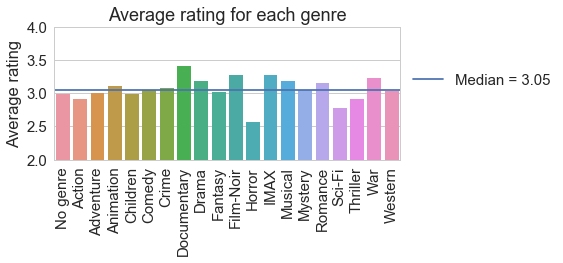

In [23]:
sns.barplot(x=list(genre_averages.keys()), y=list(genre_averages.values()))
plt.xticks(rotation=90)
plt.title('Average rating for each genre')
plt.ylabel('Average rating')
plt.ylim((2,4))
plt.axhline(y=np.median(list(genre_averages.values())), label='Median = ' + str(round(np.median(list(genre_averages.values())),2)))
plt.tight_layout()
plt.legend(loc=(1.02, 0.5))

We can see from the above plot that the median average genre rating is 3.05. Documentaries have the highest average ratings (3.4) and Horror movies have by far the lowest average ratings (2.6). 

It is worth noting that each movie is weighted the same in this calculation, so a movie with 1 review has the same weight as a movie with 10,000 reviews. Also many movies have multiple genres and are included in the calculation for each.

**Which movie has the most polarising effect on the audience (has the biggest spread of review scores)?**

In [24]:
# groupby movieId again but this time calculate the standard deviations
deviations = ratings[['movieId','rating']].groupby(by='movieId', as_index=True).std()
deviations['movie_count'] = ratings[['movieId','rating']].groupby(by='movieId', as_index=True).count()['rating']
deviations.rename(columns={'rating':'std'}, inplace=True)
deviations.sort_values(by='std', ascending=False, inplace=True)
# again limit to movies with at least 50 ratings
deviations[deviations['movie_count'] >= 50].head()

,std,movie_count
movieId,,
1311,1.744143,165
74754,1.727892,384
89281,1.645239,73
843,1.623914,63
110603,1.616805,117


In [25]:
# take the movieId of the movie with the highest standard deviation
largest_std = deviations[deviations['movie_count'] >= 50].iloc[0].name
print(movies[movies['movieId']==largest_std]['title'].values[0] + ' has:')
print('Average rating of ' + str(avg_ratings[avg_ratings['movieId']==largest_std]['rating'].values[0]))
print('Deviation of ' + str(deviations.loc[largest_std]['std']))

Santa with Muscles (1996) has:
Average rating of 2.56060606061
Deviation of 1.7441434046


Interestingly this movie has an average rating pretty much in the middle of the scale and the standard deviation that is equal to a large proportion of the distance from the mean to the maximum and minimum possible scores. Let's take a closer look at the distribution.

Text(0.5,1.05,'Rating distribution for "Santa with Muscles (1996)"')

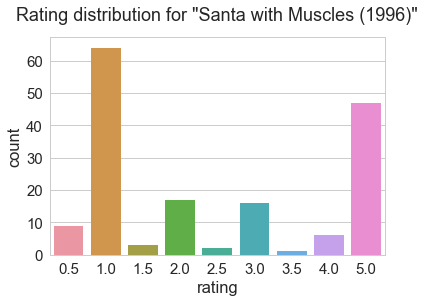

In [26]:
sns.countplot(ratings[ratings['movieId'] == largest_std]['rating'])
plt.title('Rating distribution for "Santa with Muscles (1996)"', y=1.05)

We can see that the movie was very polarising among reviewers, with the vast majority of votes being either 1.0 or 5.0. This is a Christmas movie starring former Wrestler Hulk Hogan, so it's safe to assume that the movie is terrible and the 5.0 ratings are ironic/sarcastic ratings or there are a lot of Hulk Hogan fans that use MovieLens.

## 2. Building the recommender system <a class="anchor" id="second-bullet"></a>

There are a few different types of recommender system:
* **Popularity based** : Simplest form of recommender system, will recommend that users watch the highest rated movies, because on average these have the highest probability of being liked. This works in some situations (for example [YouTube Trending](https://www.youtube.com/feed/trending) simply recommends the most viewed/liked videos from a certain timeframe.


* **Content based** : This type looks at the features of a movie (e.g. the genres, the release year, actors, producer/director) to define a similarity metric between movies. It then looks at movies the user has rated highly and recommends the most similar movies. The drawbacks of this system are that detailed information is required about each movie and similar features do not necessarily guarantee a similar quality of movie (e.g. recommending 'Sinbad: Legend of the Seven Seas', a pretty bad cartoon movie, to someone who has given 'Fight Club' a high rating based on the fact that they both have Brad Pitt in would probably not result in a happy user). An example of this is Amazon's 'Products related to this item' section on a product page.


* **Collaborative filtering** : This type of recommender looks at the past ratings of users or movies to find users or movies that have a similar rating history. For 2 similar users, User A and User B, it can then recommend movies that User A liked but User B hasn't seen to User B, and vice-versa for User A. For 2 movies that have similar rating histories, Movie A and Movie B, if a user gives Movie A a high rating then the system will likely recommend Movie B to them. This results in very personalised recommendations. An example of this is Amazon's 'Customers who bought this item also bought' section on a product page. Collaborative filtering systems suffer from 'cold-start' issues, where a user has no history and so it is difficult to tell who similar users are.

In reality, productionised recommendation systems use Hybrid combinations of the above types to provide an optimal experience for users, combining the strengths and eliminating the weaknesses of the 3 types.

We will be constructing a **collaborative filtering** system to recommend movies, as we don't have too many features for the movies and we can remove reviewers that reviewed less than a threshold number of movies to get rid of the cold-start problem.

### Data format
To create a collaborative filtering system we need the data in a specific format. We want to create a matrix where a row relates to a specific user and a column relates to a specific movie. This will have shape (n_users, n_movies).

Then, by either looking at the similarity between rows or the similarity between columns we can implement a User based filtering system or a Movie based filtering system. The user similarity matrix will have shape (n_users, n_users) and the movie similarity matrix will have shape (n_movies, n_movies).

These matrices have very large dimensions for this dataset. In fact they will be far too large to fit into the memory of my laptop (16GB) for example the user similarity matrix would have shape (271k, 271k) and assuming 32bit floating numbers for each cell we would require around 294GB of RAM. 

The rating matrix is fairly sparse and so can be stored in a more memory efficient datastructure, but the similarity matrices are completely non-sparse if all users and movies have ratings. For this reason I am significantly reducing the size of the data set for our recommendation system. 

In [27]:
# only keeping the first 2M ratings due to memory restrictions
ratings = pd.read_csv('Movie Recommender/ratings.csv')
ratings = ratings.iloc[:2000000]

In [28]:
# create a count of ratings per user
user_rating_counts = ratings[['userId','rating']].groupby(by='userId', as_index=False).count()
user_rating_counts['user_counts'] = user_rating_counts['rating']
user_rating_counts.drop('rating', axis=1, inplace=True)
user_rating_counts.head()

,userId,user_counts
0,1,27
1,2,22
2,3,10
3,4,62
4,5,26


In [29]:
# create a count of ratings per movie
movie_rating_counts = ratings[['movieId','rating']].groupby(by='movieId', as_index=False).count()
movie_rating_counts['movie_counts'] = movie_rating_counts['rating']
movie_rating_counts.drop('rating', axis=1, inplace=True)
movie_rating_counts.head()

,movieId,movie_counts
0,1,5125
1,2,1990
2,3,1153
3,4,198
4,5,1178


In [30]:
#remove all movies with less than 50 ratings and users with less than 10 ratings
ratings = pd.merge(ratings, user_rating_counts, how='left', on = 'userId')
ratings = pd.merge(ratings, movie_rating_counts, how='left', on = 'movieId')
ratings = ratings[(ratings['movie_counts'] > 50) & (ratings['user_counts'] > 10)]
ratings.head()

,userId,movieId,rating,timestamp,user_counts,movie_counts
0,1,110,1.0,1425941529,27,5091
1,1,147,4.5,1425942435,27,402
2,1,858,5.0,1425941523,27,4459
3,1,1221,5.0,1425941546,27,2853
4,1,1246,5.0,1425941556,27,2006


In [31]:
# need to create a hash table for userID and movieID because of gaps that waste memory
import collections
# userId hash table
# defaultdict is a structure that adds a key if it doesn't exist
user_dict = collections.defaultdict()

#the userId's are the keys
user_keys = set(list(ratings['userId']))

user_index = 0

# each userId gets assigned a userIndex between 0 and n_users
for key in user_keys:
    user_dict[key] = user_index
    user_index += 1

# create a reversed dictionary incase we need to get back
user_dict_rev = {v: k for k, v in user_dict.items()}

# movieId hash table
movie_dict = collections.defaultdict()
movie_keys = set(list(ratings['movieId']))

movie_index = 0
for key in movie_keys:
    movie_dict[key] = movie_index
    movie_index += 1

# create a reversed dictionary incase we need to get back
movie_dict_rev = {v: k for k, v in movie_dict.items()}

In [32]:
# create new columns in ratings dataframe
ratings['movieIndex'] = ratings['movieId'].map(movie_dict)
ratings['userIndex'] = ratings['userId'].map(user_dict)
ratings.head()

,userId,movieId,rating,timestamp,user_counts,movie_counts,movieIndex,userIndex
0,1,110,1.0,1425941529,27,5091,106,0
1,1,147,4.5,1425942435,27,402,133,0
2,1,858,5.0,1425941523,27,4459,751,0
3,1,1221,5.0,1425941546,27,2853,1019,0
4,1,1246,5.0,1425941556,27,2006,1043,0


In [33]:
n_users = ratings['userIndex'].max() + 1
n_movies = ratings['movieIndex'].max() + 1
print('There are now ' + str(n_users) + ' users.')
print('There are now ' + str(n_movies) + ' movies.')
print('The user-movie rating matrix is now ' + str(n_users*n_movies) + ' cells.')
print('The user-user correlation matrix is now ' + str(n_users*n_users) + ' cells.')

There are now 17352 users.
There are now 4632 movies.
The user-movie rating matrix is now 80374464 cells.
The user-user correlation matrix is now 301091904 cells.


We need to split the data into a training and test set. We will build the recommender system on the training set and then use the test set to evaluate predictions. It is bad practice to evaluate a model on data used to build it.

In [34]:
# we need 2 matrices with shape (n_users, n_movies) to store the train and test data in
train_matrix = np.zeros((n_users, n_movies))
test_matrix = np.zeros((n_users, n_movies))

# now we need to randomly split the 'ratings' dataframe into training and testing data
from sklearn.model_selection import train_test_split

# using a split of 90:10
train_data, test_data = train_test_split(ratings, test_size=0.1, shuffle=True, random_state=1)

In [35]:
for row in train_data.itertuples():
    # set the element at row 'userIndex' which is index 8, column 'movieIndex' which is index 7
    # to be equal to the 'rating' which is index 3
    train_matrix[row[8], row[7]] = row[3]

# similar process for the test data
for row in test_data.itertuples():
    test_matrix[row[8], row[7]] = row[3]

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# this creates the similarity between rows (users)
user_similarities = cosine_similarity(train_matrix)

# this creates the similarity between columns (movies)
movie_similarities = cosine_similarity(train_matrix.T)

Let's create a function that can get the most similar movies to a chosen movie. Note that cosine similarity varies from -1 (completely opposite) to 1 (exactly the same). Therefore we want to get the movies with the highest cosine similarities with a given movie.

In [37]:
def similar_movies(movie_title, movies=movies, movie_dict=movie_dict, movie_similarities=movie_similarities, movie_dict_rev=movie_dict_rev):
    '''Takes in a movie title (consistent with the titles in the movies dataframe) and returns the 
    5 most similar movies, based purely upon similarity of rating history'''
    
    # get the movieId by looking up title in the movies dataframe
    movieId = movies[movies['title'] == movie_title]['movieId'].values[0]
    # use movie_dict to get the movieIndex
    movieIndex = movie_dict[movieId]
    
    # grab the corresponding row of the movie similarity matrix
    movieVector = movie_similarities[movieIndex, :]
    
    # argsort the row, so we know 
    movieVector_args = np.argsort(movieVector)
    
    # extract the indices of the 5 largest values
    # reverse it because the largest is at the end
    indices = list(reversed(movieVector_args[-5:]))
    # get the similarity value for each of the indices extracted
    similarities=[movieVector[arg] for arg in indices]
    
    ids = [movie_dict_rev[index] for index in indices]
    titles = [movies[movies['movieId'] == Id]['title'].values[0] for Id in ids]
    
    for title, similarity in zip(titles, similarities):
        print(title + ' : ' + str(similarity))

In [38]:
similar_movies('Star Wars: Episode V - The Empire Strikes Back (1980)')

Star Wars: Episode V - The Empire Strikes Back (1980) : 1.0
Star Wars: Episode IV - A New Hope (1977) : 0.710802762324
Star Wars: Episode VI - Return of the Jedi (1983) : 0.697117387319
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : 0.651978974751
Indiana Jones and the Last Crusade (1989) : 0.591202298253


In [39]:
similar_movies('Fight Club (1999)')

Fight Club (1999) : 1.0
Matrix, The (1999) : 0.590987863202
Memento (2000) : 0.562552065916
American Beauty (1999) : 0.548615358274
Lord of the Rings: The Fellowship of the Ring, The (2001) : 0.541258035677


The first movie that is returned is always the query movie. This is because the angle between a vector and itself will always be zero, and the cosine of zero is 1. Then we get some other movies. Querying Star Wars Episode V returns Episodes IV and VI along with 2 Indiana Jones movies that were released around the same time. These 2 movie franchises have similar cult followings.

Querying Fight Club returns The Matrix, Memento, American Beauty and LOTR. These were all released around the same year and (except LOTR) all have strong psychological components to the plotline.

Without any details on the movies themselves, we have been able to identify movies that are similar in nature to a query movie and that are likely to be good recommendations to people that liked the query movie. 

### Predicting ratings for unseen movies
The next step is to take a users history and an unseen movie and predict the users rating for that movie. There are 2 ways to predict a rating:

1. **User Based** - Look at how users similar to the query user rated the movie and calculate a weighted sum. Because different users will have different interpretations of what ratings are good or bad, the ratings must be normalized to show the difference between the users mean rating and the rating for the current movie.
2. **Movie Based** - Look at how the user rated movies similar to the query movie and calculate a weighted sum. This does not require adjustment to the mean because only the current users ratings are used in the sum. 

For the User Based method, the predicted rating of user k for movie m is then:

\begin{equation*}
\hat{y}_{k,m} = \bar{y}_{k} + \frac{\sum{sim_{user}(user_{k}, user_{a})(y_{a,m} - \bar{y}_{a})}}{\sum{\lvert sim_{user}(user_{k}, user_{a})\rvert}}
\end{equation*}

For the Movie Based method, the predicted rating of user k for movie m is then:

\begin{equation*}
\hat{y}_{k,m} = \frac{\sum{sim_{movie}(movie_{m}, movie_{a})y_{k,a}}}{\sum{\lvert sim_{movie}(movie_{m}, movie_{a})\rvert}}
\end{equation*}

Care must be taken when making predictions, because our training matrix has zero's where a user did not rate a movie. If we use this matrix directly, these will be treated as actual ratings of zero and will pull our predictions towards zero artificially.

### Evaluation
A number of metrics could be used to compare the predicted ratings with the actual ratings held back in the test set. Two of the most commonly used metrics are Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). The equations for both are shown below: 

\begin{equation*}
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y}_i)^2}
\end{equation*}

\begin{equation*}
MAE = \frac{1}{N}\sum_{i=1}^N \lvert y_i - \hat{y}_i \rvert
\end{equation*}

Where $y$ is the actual rating and $\hat{y}$ is the predicted rating and N is the number of test points. MAE has the advantage that it is directly interpretable on the scale of the ratings, as it is simply the mean distance between the predicted ratings and the actual ratings.

For both the user-based and movie-based predictions we will calculate both quality metrics. I will walk through the prediction process for a single user and movie pair first.

**User based prediction for a single user-movie pair**

In [40]:
# user 0 has entries in the following movieIndex's in the test matrix
# therefore we need to make predictions for these movies
test_matrix[0,:].nonzero()

(array([ 715, 1186, 1541, 4477], dtype=int64),)

In [41]:
# for movieIndex 715 we need to find all users that DID rate the movie in the training set
# we use the users with userIndex below to calculate our prediction
train_matrix[:,715].nonzero()

(array([    4,    27,    30, ..., 17282, 17286, 17305], dtype=int64),)

In [42]:
# user similarities for current user with users found above
sims= user_similarities[0, train_matrix[:,715].nonzero()]
sims

array([[ 0.17906124,  0.12489677,  0.        , ...,  0.08038237,
         0.08282088,  0.09935196]])

In [43]:
# average rating for each user, ignoring values that are zero
mean_user_ratings = np.nanmean(np.where(train_matrix!=0,train_matrix,np.nan),1, keepdims=True)
mean_user_ratings

C:\Users\phil_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


array([[ 4.15909091],
       [ 3.2       ],
       [ 3.60784314],
       ..., 
       [ 3.45454545],
       [ 3.1       ],
       [ 3.20052083]])

In [44]:
mean_user_ratings.shape

(17352, 1)

In [45]:
# the difference between users average ratings and their ratings for movieIndex 715
diff = train_matrix[train_matrix[:,715].nonzero(), 715] - mean_user_ratings[train_matrix[:,715].nonzero(),0]
diff

array([[-1.35555556,  0.82040816,  0.15625   , ..., -2.59550562,
         1.16825776,  1.28439597]])

In [46]:
# now we calculate the dot product of the similarities with the rating difference above
# then divide by the sum of the similarities and add it all to userIndex 0's mean rating
pred = mean_user_ratings[0] + np.dot(sims, diff.T)/np.sum(sims)
pred

array([[ 4.39883536]])

In [47]:
# the actual rating
test_matrix[0,715]

4.0

Not bad! We predicted that the rating would be 4.4 and the actual rating was 4.0, just based on the rating that other users gave the movie and their similarity to the user with index 0.

Let's calculate a prediction using the movie similarity instead.

**Movie-based prediction for a single user-movie pair**

In [48]:
# list of all the movieIndex's that user with index 0 actually rated
train_matrix[0,:].nonzero()

(array([ 106,  133,  470,  751,  878, 1013, 1019, 1043, 1156, 1538, 2148,
        2196, 2255, 2285, 3107, 3147, 3438, 3658, 3764, 3938, 4173, 4609], dtype=int64),)

In [49]:
# similarities of movie 715 with these movies
movie_sims = movie_similarities[715, train_matrix[0,:].nonzero()]

In [50]:
movie_ratings = train_matrix[0, train_matrix[0,:].nonzero()]

In [51]:
# make prediction using dot product of movie_sims and the ratings user 0 gave them
# divided by the sum of the similarities
movie_pred = np.dot(movie_sims, movie_ratings.T)/np.sum(movie_sims)
movie_pred

array([[ 4.07189941]])

Wow! The movie similarity prediction was 4.07 compared to the actual rating of 4.0. This is incredibly close considering it's purely based on the users ratings of other movies and the similarity of the rating history between those movies and movie 715.

The accuracy of a specific prediction will be dependent on how many ratings for the user/movie of interest we have in the dataset, so for some pairs one method might be better and for some pairs the other might be better.

Now we can write functions that will perform the above steps for every non-zero entry in the test matrix, and then we can evaluate the overall performance of both methods using our defined evaluation metrics.

**Predictions for the entire test matrix**

In [52]:
def predict_users(train=train_matrix, test=test_matrix,  sims = user_similarities):
    '''Function that takes in the training matrix, testing matrix and the user similarity matrix
    and calculates predicted user ratings for each user/movie pair present in the test matrix.'''
    # create an empty output matrix the same size as test
    output = np.zeros((test.shape))
    
    # calculate the mean values for later use
    mean_user_ratings = np.nanmean(np.where(train!=0,train,np.nan),1, keepdims=True)
    mean_movie_ratings = np.nanmean(np.where(train!=0, train, np.nan), 0, keepdims=True)
    
    #check every row of the test matrix for non-zero values
    for i in range(len(test)):
        nonzero_test = test[i,:].nonzero()
        
        #if non-zero isn't empty, we need to do some calculations
        if list(nonzero_test[0]) != []:
            #first check that we have training data for that user
            nonzero_train = train[i,:].nonzero()
            # if there is training data for that user then continue
            if list(nonzero_train[0]) != []:
                #loop over movie indices in the array
                for j in list(nonzero_test[0]):
                    #find the other users that rated the movie and the similarities of those users with the current user
                    other_users = train[:,j].nonzero()
                    user_sims= sims[i, other_users]

                    #find the difference between the ratings for this movie and the average ratings
                    diff = train[other_users, j] - mean_user_ratings[other_users,0]

                    # calculate prediction
                    pred = mean_user_ratings[i] + np.dot(user_sims, diff.T)/np.sum(user_sims)

                    #set value of output matrix equal to prediction
                    output[i,j] = pred
            else:
                #if there is no training data, then just return the average rating for each movie
                for j in list(nonzero_test[0]):
                    pred = mean_movie_ratings[0,j]
                    
                    output[i,j] = pred
                
    return output

In [53]:
def predict_movies(train=train_matrix, test=test_matrix,  sims = movie_similarities):
    '''Function that takes in the training matrix, testing matrix and the movie similarity matrix
    and calculates predicted user ratings for each user/movie pair present in the test matrix.'''
    # create an empty output matrix the same size as test
    output = np.zeros((test.shape))
    
    # calculate the mean values for later use
    mean_movie_ratings = np.nanmean(np.where(train!=0, train, np.nan), 0, keepdims=True)
    
    #check every row of the test matrix for non-zero values
    for i in range(len(test)):
        nonzero_test = test[i,:].nonzero()
        
        #if non-zero isn't empty, we need to do some calculations
        if list(nonzero_test[0]) != []:
            #first check that we have training data for that user
            nonzero_train = train[i,:].nonzero()
            # if there is training data for that user then continue
            if list(nonzero_train[0]) != []:
                #loop over movie indices in the array
                for j in list(nonzero_test[0]):
                    #find the indices of other movies that the user rated
                    other_ratings_indices = train[i,:].nonzero()
                    #find the similarities between the test movie and the other movies the user rated
                    movie_sims= sims[j, other_ratings_indices]

                    #find the actual ratings the user gave these movies
                    other_ratings = train[i, other_ratings_indices]

                    # calculate prediction
                    pred = np.dot(movie_sims, other_ratings.T)/np.sum(movie_sims)

                    #set value of output matrix equal to prediction
                    output[i,j] = pred
            else:
                #if there is no training data, then just return the average rating for each movie
                for j in list(nonzero_test[0]):
                    pred = mean_movie_ratings[0,j]
                    
                    output[i,j] = pred
                
    return output

In [54]:
user_preds = predict_users()

C:\Users\phil_\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [55]:
movie_preds = predict_movies()

Note that the runtime warning above is caused by one user for whom all of the ratings were randomly assigned to the test matrix. This means that when we try to calculate the mean rating for that user, we get a NaN value. The functions above have tests to catch this error and the predictions for that user are simply the mean rating for each movie.

**Evaluation functions**

In [56]:
def calc_RMSE(predictions, actual_ratings):
    
    # only want to calculate on values that are non-zero in the test data
    
    predictions = predictions[actual_ratings.nonzero()]
    actual_ratings = actual_ratings[actual_ratings.nonzero()]
    
    rmse = np.sqrt(np.mean((predictions - actual_ratings)**2))
    
    return rmse

In [57]:
print('The RMSE for the user-based method is '+ str(round(calc_RMSE(user_preds, test_matrix), 3)))
print('The RMSE for the movie-based method is '+ str(round(calc_RMSE(movie_preds, test_matrix), 3)))

The RMSE for the user-based method is 0.865
The RMSE for the movie-based method is 0.92


In [58]:
def calc_MAE(predictions, actual_ratings):
    
    # only want to calculate on values that are non-zero in the test data
    
    predictions = predictions[actual_ratings.nonzero()]
    actual_ratings = actual_ratings[actual_ratings.nonzero()]
    
    mae = np.mean(np.abs(predictions - actual_ratings))
    
    return mae

In [59]:
print('The MAE for the user-based method is '+ str(round(calc_MAE(user_preds, test_matrix), 3)))
print('The MAE for the movie-based method is '+ str(round(calc_MAE(movie_preds, test_matrix), 3)))

The MAE for the user-based method is 0.66
The MAE for the movie-based method is 0.709


These seem like decent scores! The user-based method has the lowest overall error over the testing setm despite the movie-based method winning for the single example we walked through, which emphasises my point about the accuracy depending on the available data.

We can see that, on average, the user-based method predicts a score 0.66 away from the actual rating. 

**But is this actually a good score?** 

One way to test if this is a good score is to see how well a model that just predicts the average rating for every movie performs.

In [60]:
def predict_means(train= train_matrix, test = test_matrix):
    '''Takes in the train and test matrices and outputs a prediction matrix where every non-zero cell
    of the test matrix has the average score for that movie'''
    
    # create an empty output matrix the same size as test
    output = np.zeros((test.shape))
    
    # calculate the mean values for later use
    mean_movie_ratings = np.nanmean(np.where(train!=0, train, np.nan), 0, keepdims=True)
    
    #check every row of the test matrix for non-zero values
    for i in range(len(test)):
        nonzero_test = test[i,:].nonzero()
        
        #if non-zero isn't empty, we need to do some calculations
        if list(nonzero_test[0]) != []:
            
            #loop over movie indices in the array
            for j in list(nonzero_test[0]):
                
                # predict the mean value
                pred = mean_movie_ratings[0, j]

                #set value of output matrix equal to prediction
                output[i,j] = pred
    
    return output

In [61]:
mean_preds = predict_means()

In [62]:
print('The RMSE for the mean method is '+ str(round(calc_RMSE(mean_preds, test_matrix), 3)))
print('The MAE for the mean method is '+ str(round(calc_MAE(mean_preds, test_matrix), 3)))

The RMSE for the mean method is 0.947
The MAE for the mean method is 0.733


Both of our methods have lower error than the mean method, so we can say that our model would provide better recommendations to users.

It is worth noting that to actually provide recommendations to a user we would predict scores for movies they haven't seen and recommend the ones with the highest predicted scores.

## 3. Improvements/Further Work <a class="anchor" id="third-bullet"></a>

To summarise:
* We have implemented both user-based and item-based collaborative filtering using the MovieLens data set
* A test set was held back for evaluation purposes
* For each user/movie pair in the test set we used both methods to predict a rating 
* Comparing this rating with the actual rating we were able to compute RMSE and MAE scores for the model
* Both models were more accurate than a baseline model that simply predicted the average score for each movie
* The best case MAE was 0.66, meaning that on average the predictions were 0.66 away from the actual rating.

There are a number of things that could improve the model.
1. **More data**: The quality of the predictions is dependent on the quality of the similarities calculated between users and items. Using a larger subsection of the data set should lead to reduced errors.
2. **Nearest Neighbours**: Currently, the user-based method uses the rating of every other user that rated a particular movie. Whilst dissimilar users contributions are weighted to be small, there is still a contribution. We could instead take the weighted sum of only the N most similar users (or N most similar movies for the movie-based model). It would be interesting to implement this and see how the error varies with N.
3. **Capping/Rounding**: The predictions that we have made could take on any continuous value above zero, whereas the rating scale for the original data was 0.5 to 5 in increments of 0.5. If we were to limit our predictions so anything below 0.5 is set to 0.5, anything above 5 is set to 5 and anything inbetween is rounded to the nearest 0.5 would this improve or degrade performance?
4. **Singular Value Decomposition (SVD)**: Instead of using the cosine similarity metric, SVD can be used to 'learn' similarities between users and between features. This can then be used to build the prediction.
5. **Time weighting**: The MovieLens dataset incorporates ratings from 1995 to 2017. As a movie gets older it is possible that for example the computer graphics used don't age well and users watching it now will perceive it to be worse. The ratings could be weighted by how recent they are, with more recent ratings counting for more.

I intend to create another post exploring some of the above improvements with the same dataset, so we can see any benefits relative to this first implementation.

Thanks for reading!